In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from scipy.interpolate import UnivariateSpline
import sys
import os
from scipy import optimize
from scipy import constants
import scipy as scp
from scipy.signal import butter,filtfilt

import shelve as shv

import json 
from pandas import Series
from pandas import Timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy import stats 
import h5py
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

SMALL_SIZE = 6
MEDIUM_SIZE = 7
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from numba import jit, njit, prange

eCharge= 1.602e-19
cm = 1/2.54



FEV = np.genfromtxt('gapsweep/fe_50nm.txt', delimiter=',')
phase = np.genfromtxt('gapsweep/phase_50nm.txt', delimiter=',')
wavelength = np.genfromtxt('gapsweep/wavelength_in_um.txt', delimiter=',')

c= 2.99792458e8


convFactor = 160e-6 # 140uV per e/fs??? I think this is wrong 


## Model for CEP Dependent Current Scaling


(-5e-13, 5e-13)

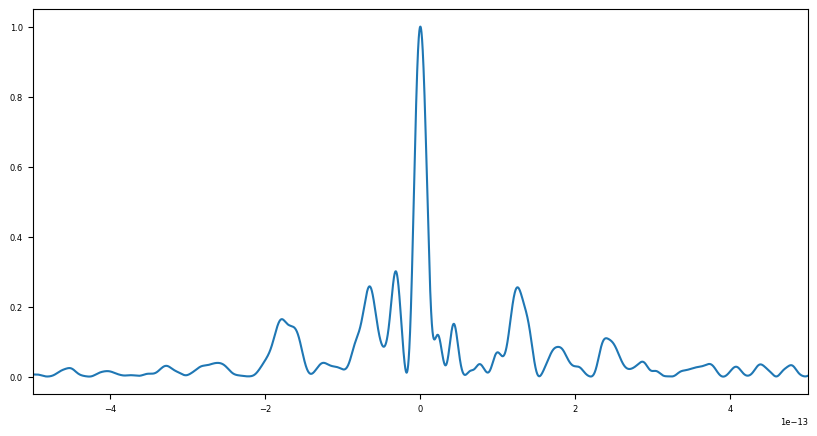

In [2]:
# Trying the fitting procedure
from scipy.signal import hilbert

timeAxis = np.genfromtxt('eFieldPlasmonTime04112022.csv',delimiter=',')
eField = hilbert(np.genfromtxt('eLFieldPlasmon04112022.csv',delimiter=','))
#timeAxis = np.genfromtxt('TimeMIR.csv',delimiter=',')
#eField = hilbert(np.genfromtxt('eFieldMIR.csv',delimiter=','))



eFieldNorm = np.exp(-1j*0)*eField/np.max(np.abs(eField))
idx1 =(np.abs(eFieldNorm)**2).argmax()
timeAxis = timeAxis-timeAxis[idx1]

plt.plot(timeAxis,np.abs(eFieldNorm)**2)
plt.xlim([-0.5e-12,0.5e-12])



In [3]:
# Definition of the FN function
fnFCN = lambda E,fcrit: np.sign(np.real(E))* np.real(E)**2 * np.exp(-fcrit/(np.abs(np.real(E))))



def J_sfn(F, W_f):
    # Set all negative field values to zero
    F[F < 0] = 0 

    # Constants for the equation
    a_const = 1.541534e-6
    b_const = 6.83089

    f = 1.43996453529595 * F / W_f**2
    v_f = 1 - f + (1 / 6) * f * np.log(np.abs(f))

    J = a_const / W_f * F**2 * np.exp(-v_f * b_const * W_f**1.5 / F)
    
    # Replace NaN values with 0
    J[np.isnan(J)] = 0
    
    return J






/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_56066/2768172423.py:15: RuntimeWarning: divide by zero encountered in log
  v_f = 1 - f + (1 / 6) * f * np.log(np.abs(f))
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_56066/2768172423.py:15: RuntimeWarning: invalid value encountered in multiply
  v_f = 1 - f + (1 / 6) * f * np.log(np.abs(f))


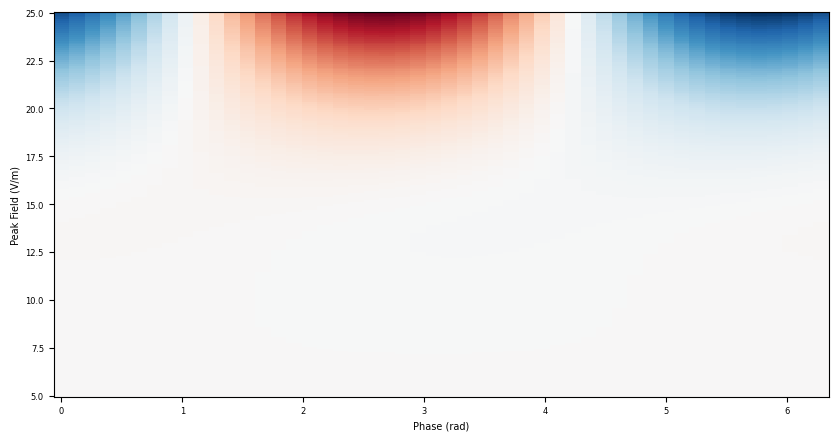

In [4]:

eList = np.linspace(5,25,200)
phaseList = np.linspace(0,2*np.pi,50)
cepMIREscan = np.zeros([len(eList),len(phaseList)]) # Model 1 
cepMIREscan2 = np.zeros([len(eList),len(phaseList)]) # Model 2

FE = 1

for j in range(len(phaseList)):
    for i in range(len(eList)):
        cepMIREscan[i,j]=np.sum(fnFCN((-np.exp(1j*phaseList[j])*eFieldNorm*FE*eList[i]),78.7))
        cepMIREscan2[i,j]=(np.trapz(628*J_sfn(np.real(-np.exp(1j*phaseList[j])*eFieldNorm*FE*eList[i]),5.1)- 628*J_sfn(np.real(np.exp(1j*phaseList[j])*eFieldNorm*FE*eList[i]),5.1),timeAxis))/eCharge



    
plt.pcolormesh(phaseList,eList,(cepMIREscan),rasterized=True,cmap='RdBu_r')
plt.xlabel('Phase (rad)')
plt.ylabel('Peak Field (V/m)')
plt.show()
#plt.ylabel('cep current (arb. u.)')


/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_56066/833428613.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  out[i] = np.trapz(cepMIREscan[i,:]*np.exp(1j*phaseList),phaseList)
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_56066/833428613.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  out2[i] = np.trapz(cepMIREscan2[i,:]*np.exp(1j*phaseList),phaseList)


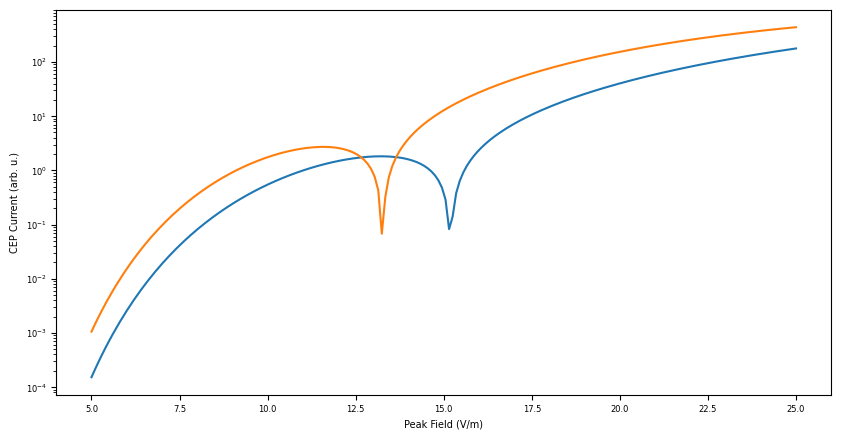

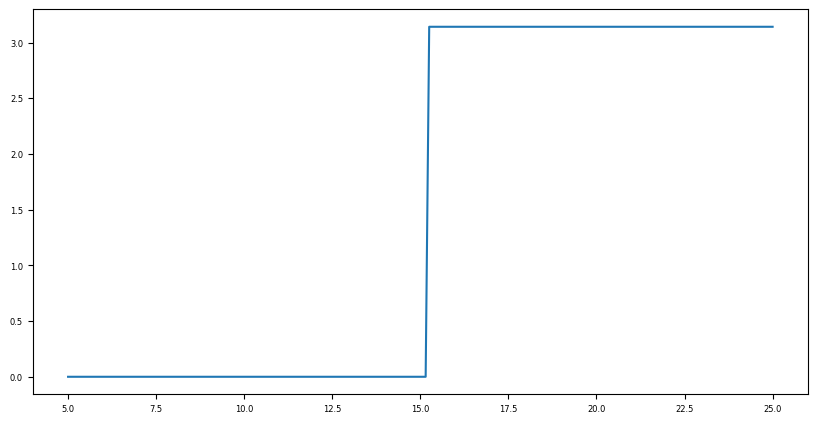

In [5]:
out=np.zeros(len(eList))
out2=np.zeros(len(eList))

for i in range(len(eList)):
    out[i] = np.trapz(cepMIREscan[i,:]*np.exp(1j*phaseList),phaseList)
    out2[i] = np.trapz(cepMIREscan2[i,:]*np.exp(1j*phaseList),phaseList)

plt.semilogy(eList,np.abs(out))
plt.semilogy(eList,np.abs(out2))
#plt.xlim([0,4])
#plt.ylim([-4,4])
plt.xlabel('Peak Field (V/m)')
plt.ylabel('CEP Current (arb. u.)')

plt.show()



plt.plot(eList,np.angle(out))
plt.show()

## Calculation of Peak Current Observed in the Measurements

Residual Charge: 3.2825484764542936 electrons


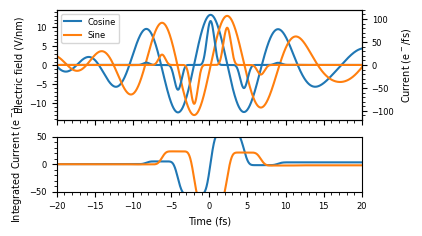

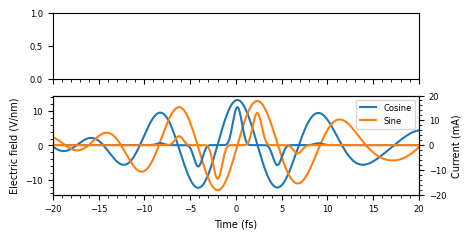

peak current 95.6064547767942 e/fs
peak current 15.297032764287072 mA


In [6]:



FE = 7.8
eField = -eFieldNorm * FE * 1.7

cep = -0.2

measMax = 2370 # Taken from last index of 4IMCT3_03112022V2
antennaN = 722 # Taken from 4IMCT3_03112022V2


preFactor =  (1/antennaN)*measMax/np.trapz(fnFCN((np.exp(1j*cep)*eField),78.7),timeAxis)

print(f"Residual Charge: {preFactor*np.trapz(fnFCN((np.exp(1j*cep)*eField),78.7),timeAxis)} electrons")

currentCos = preFactor*fnFCN((np.exp(1j*cep)*eField),78.7)
currentSine = preFactor*fnFCN((np.exp(1j*(cep-np.pi/2))*eField),78.7)

fig, ax1 = plt.subplots(2,1,gridspec_kw={'height_ratios': [2,1]},sharex=True,figsize=(cm*10,cm*6))

ax1[0].plot(timeAxis*1e15,np.real(np.exp(1j*cep)*eField))
ax1[0].plot(timeAxis*1e15,np.real(np.exp(1j*(cep-np.pi/2))*eField))

ax1[0].set_xlim([-20,20])
ax1[0].minorticks_on()

ax1[0].set_ylabel('Electric field (V/nm)')
ax1[0].legend(['Cosine','Sine'])
ax2 = ax1[0].twinx()
ax2.plot(timeAxis*1e15,currentCos*1e-15)
ax2.plot(timeAxis*1e15,currentSine*1e-15)
ax2.minorticks_on()


ax2.set_ylabel('Current (e$^-$/fs)')
ax2.set_ylim([-120,120])
ax1[1].plot(timeAxis*1e15,np.cumsum(currentCos)*np.mean(np.abs(np.diff(timeAxis))))
ax1[1].plot(timeAxis*1e15,np.cumsum(currentSine)*np.mean(np.abs(np.diff(timeAxis))))
ax1[1].set_ylabel('Integrated Current (e$^-$)')
ax1[1].set_ylim([-50,50])
ax1[1].minorticks_on()

ax1[1].set_xlabel('Time (fs)')
plt.savefig('MIRCurrentPrinciple.pdf',bbox_inches='tight')

plt.show()



fig, ax1 = plt.subplots(2,1,gridspec_kw={'height_ratios': [1,1.5]},sharex=True,figsize=(cm*12,cm*6))

ax1[1].plot(timeAxis*1e15,np.real(np.exp(1j*cep)*eField))
ax1[1].plot(timeAxis*1e15,np.real(np.exp(1j*(cep-np.pi/2))*eField))


ax1[1].set_xlim([-20,20])
ax1[1].minorticks_on()

ax1[1].set_ylabel('Electric field (V/nm)')
ax1[1].legend(['Cosine','Sine'])
ax2 = ax1[1].twinx()
ax2.plot(timeAxis*1e15,currentCos*1e-15*convFactor*1e3)
ax2.plot(timeAxis*1e15,currentSine*1e-15*convFactor*1e3)
ax2.minorticks_on()


ax2.set_ylabel('Current (mA)')
ax2.set_ylim([-20,20])


ax1[1].set_xlabel('Time (fs)')
plt.savefig('MIRCurrentPrincipleAmp.pdf',bbox_inches='tight')

plt.show()

print(f"peak current {np.max(currentCos*1e-15)} e/fs")
print(f"peak current {np.max(currentCos*1e-15*convFactor*1e3)} mA")

##  Current Duration

Pulse duration: 1.1259555770048004


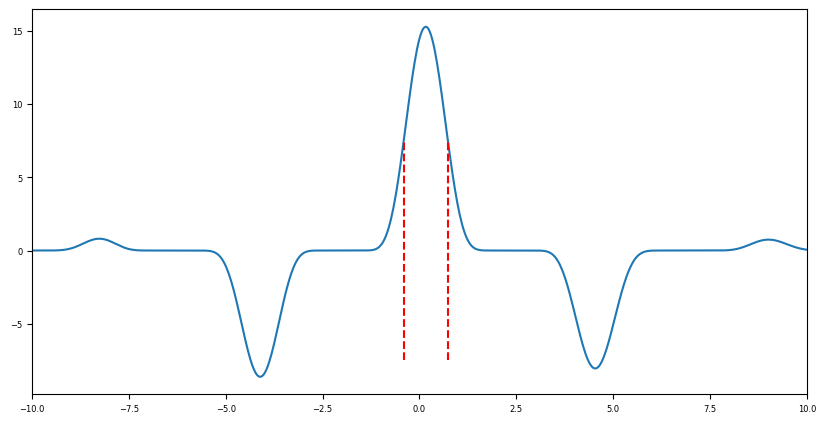

In [7]:
plt.plot(timeAxis*1e15,currentCos*1e-15*convFactor*1e3)
plt.xlim([-10,10])
#plt.ylim([-7.5,7.5])
spline = UnivariateSpline(timeAxis*1e15, (currentCos/np.max(currentCos))-0.5,s=0,k=3)

plt.vlines(spline.roots(),-7.5,7.5,colors='r',linestyles='dashed')

r1 = spline.roots()
print('Pulse duration:',np.abs(r1[0]-r1[-1]))



# Modelling of a Single Antenna

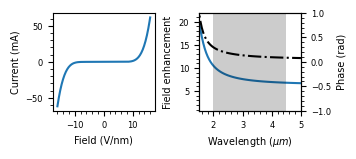

In [8]:
fieldValues = np.linspace(-16,16,200)
currentValues = preFactor*fnFCN((fieldValues),78.7)


fig,ax = plt.subplots(1,2,figsize=(cm*9,cm*4))

ax[0].plot(fieldValues,currentValues*1e-15*convFactor*1e3)
ax[0].set_xlabel('Field (V/nm)')
ax[0].set_ylabel('Current (mA)')
ax[0].minorticks_on()


ax[1].plot(wavelength  ,FEV)
ax[1].set_ylabel('Field enhancement')
ax[1].minorticks_on()
ax[1].set_xlabel('Wavelength ($\mu m$)')
ax[1].set_xlim([1.5,5])
ax2 = ax[1].twinx()
ax2.plot(wavelength[1:],phase[1:],linestyle='-.',color='k')
ax2.minorticks_on()
ax2.set_ylabel('Phase (rad)')
ax2.set_ylim([-1,1])
ax2.axvspan(2,4.5,0,1,facecolor='k',alpha=0.2)


fig.tight_layout(h_pad=1, w_pad=1)


fig.savefig('FEandPhase.pdf')


plt.savefig('DiodeResponse.pdf')

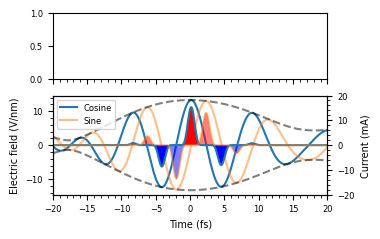

In [9]:

fig, ax1 = plt.subplots(2,1,gridspec_kw={'height_ratios': [1,1.5]},sharex=True,figsize=(cm*9,cm*6))


ax1[1].plot(timeAxis*1e15,np.real(np.exp(1j*cep)*eField))
ax1[1].plot(timeAxis*1e15,np.real(np.exp(1j*(cep-np.pi/2))*eField),alpha=0.5)
ax1[1].plot(timeAxis*1e15,np.abs(np.exp(1j*(cep-np.pi/2))*eField),'k--',alpha=0.5)
ax1[1].plot(timeAxis*1e15,-np.abs(np.exp(1j*(cep-np.pi/2))*eField),'k--',alpha=0.5)


ax1[1].set_xlim([-20,20])
ax1[1].minorticks_on()

ax1[1].set_ylabel('Electric field (V/nm)')
ax1[1].legend(['Cosine','Sine'])
ax2 = ax1[1].twinx()
ax2.plot(timeAxis*1e15,currentCos*1e-15*convFactor*1e3)
ax2.fill_between(timeAxis*1e15,currentCos*1e-15*convFactor*1e3,0,where=currentCos*1e-15*convFactor*1e3>0,facecolor='r',alpha=1)
ax2.fill_between(timeAxis*1e15,currentCos*1e-15*convFactor*1e3,0,where=currentCos*1e-15*convFactor*1e3<0,facecolor='b',alpha=1)



ax2.plot(timeAxis*1e15,currentSine*1e-15*convFactor*1e3,alpha=0.5)
ax2.fill_between(timeAxis*1e15,currentSine*1e-15*convFactor*1e3,0,where=currentSine*1e-15*convFactor*1e3>0,facecolor='r',alpha=0.5)
ax2.fill_between(timeAxis*1e15,currentSine*1e-15*convFactor*1e3,0,where=currentSine*1e-15*convFactor*1e3<0,facecolor='b',alpha=0.5)

ax2.minorticks_on()


ax2.set_ylabel('Current (mA)')
ax2.set_ylim([-20 , 20])


ax1[1].set_xlabel('Time (fs)')
plt.savefig('MIRCurrentPrincipleAmp.pdf',bbox_inches='tight')

plt.show()

# General Keldysh Rate
I follow the derivation of Michael Krügers Thesis - https://edoc.ub.uni-muenchen.de/16245/1/Krueger_Michael.pdf
using:

$
\gamma = \sqrt{\frac{\phi}{2U_p}}\\
U_p = \frac{q^2E_0^2}{4m\omega^2}\\
$

Krüger gives as a result the cycle averaged momentum integrated photoemission rate (page 12):

$
P(\gamma) \propto e^{-\frac{2\phi}{\hbar\omega}\left(\left(1+\frac{1}{2\gamma^2}\right)\text{acrsinh}(\gamma) -\frac{\sqrt{1+\gamma^2}}{2\gamma} \right)}
$

I think i cannot use this as a quasi static approximation...
Let's do it, for the arguments sake.

In [10]:
wvlgth = 2642e-9
f = lambda x: (2*np.pi/wvlgth)*np.sqrt(2*511e3*5.1)/(7.2*x) # 7.4 is the FE scaling Factor

gamma = f(np.real(eFieldNorm))

genEmissionrate = lambda x: np.exp(-(2*5.3/0.47)*((1+1/(2*x**2))*np.arcsinh(x)-np.sqrt(1+x**2)/2*x))

0.029903374214450145


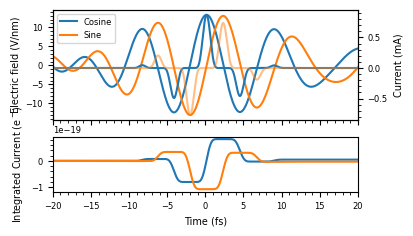

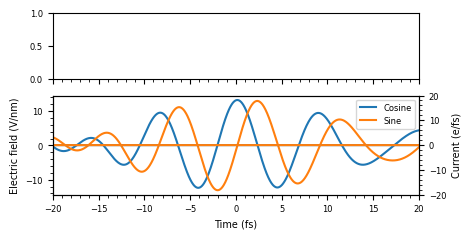

1.3935297480062985e-19
2.229647596810078e-20


In [11]:


FE = 7.8
eField = -eFieldNorm * FE * 1.7

cep = -0.2

measMax = 2370 # Taken from last index of 4IMCT3_03112022V2
antennaN = 722 # Taken from 4IMCT3_03112022V2
fudgeFactor = 1

preFactor = 10*20*1.5e-6

print(1e15*preFactor*np.trapz(fnFCN((np.exp(1j*cep)*eField),78.7),timeAxis)/convFactor)

currentCos = preFactor*fnFCN((np.exp(1j*cep)*eField),78.7)
currentSine = preFactor*fnFCN((np.exp(1j*(cep-np.pi/2))*eField),78.7)

fig, ax1 = plt.subplots(2,1,gridspec_kw={'height_ratios': [2,1]},sharex=True,figsize=(cm*10,cm*6))

ax1[0].plot(timeAxis*1e15,np.real(np.exp(1j*cep)*eField))
ax1[0].plot(timeAxis*1e15,np.real(np.exp(1j*(cep-np.pi/2))*eField))

ax1[0].set_xlim([-20,20])
ax1[0].minorticks_on()

ax1[0].set_ylabel('Electric field (V/nm)')
ax1[0].legend(['Cosine','Sine'])
ax2 = ax1[0].twinx()
ax2.plot(timeAxis*1e15,currentCos/convFactor)
ax2.plot(timeAxis*1e15,currentSine/convFactor,alpha=0.5)
ax2.minorticks_on()


ax2.set_ylabel('Current (mA)')
#ax2.set_ylim([-120,120])
ax1[1].plot(timeAxis*1e15,np.cumsum(currentCos)*np.mean(np.abs(np.diff(timeAxis))))
ax1[1].plot(timeAxis*1e15,np.cumsum(currentSine)*np.mean(np.abs(np.diff(timeAxis))))
ax1[1].set_ylabel('Integrated Current (e$^-$)')
#ax1[1].set_ylim([-50,50])
ax1[1].minorticks_on()

ax1[1].set_xlabel('Time (fs)')
plt.savefig('MIRCurrentPrinciple.pdf',bbox_inches='tight')

plt.show()



fig, ax1 = plt.subplots(2,1,gridspec_kw={'height_ratios': [1,1.5]},sharex=True,figsize=(cm*12,cm*6))

ax1[1].plot(timeAxis*1e15,np.real(np.exp(1j*cep)*eField))
ax1[1].plot(timeAxis*1e15,np.real(np.exp(1j*(cep-np.pi/2))*eField))


ax1[1].set_xlim([-20,20])
ax1[1].minorticks_on()

ax1[1].set_ylabel('Electric field (V/nm)')
ax1[1].legend(['Cosine','Sine'])
ax2 = ax1[1].twinx()
ax2.plot(timeAxis*1e15,currentCos*1e-15*convFactor*1e3)
ax2.plot(timeAxis*1e15,currentSine*1e-15*convFactor*1e3)
ax2.minorticks_on()


ax2.set_ylabel('Current (e/fs)')
ax2.set_ylim([-20,20])


ax1[1].set_xlabel('Time (fs)')
plt.savefig('MIRCurrentPrincipleAmp.pdf',bbox_inches='tight')

plt.show()

print(np.max(currentCos*1e-15))
print(np.max(currentCos*1e-15*convFactor*1e3))

In [12]:

def J_sfn(F, W_f):
    # Set all negative field values to zero
    F[F < 0] = 0 

    # Constants for the equation
    a_const = 1.541534e-6
    b_const = 6.83089

    f = 1.43996453529595 * F / np.power(W_f, 2)
    v_f = 1 - f + (1 / 6) * f * np.log(np.abs(f))

    J = a_const / W_f * np.power(F, 2) * np.exp(-v_f * b_const * np.power(W_f, 1.5) / F)
    
    # Replace NaN values with 0
    J[np.isnan(J)] = 0
    
    return J





/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_56066/2371911145.py:10: RuntimeWarning: divide by zero encountered in log
  v_f = 1 - f + (1 / 6) * f * np.log(np.abs(f))
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_56066/2371911145.py:10: RuntimeWarning: invalid value encountered in multiply
  v_f = 1 - f + (1 / 6) * f * np.log(np.abs(f))


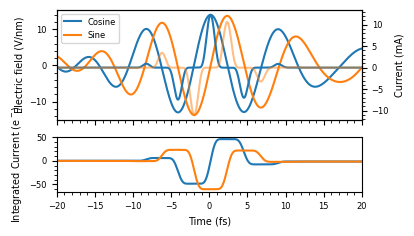

-1.4421113365614335


In [13]:

FE = 8.2 #7.8

pulse = lambda t,tau,wvlgth,cep: np.exp(-2 * np.log(2) * (t)**2 / (tau*1e-15)**2)*np.exp(1j*(2*np.pi*t*c/(wvlgth*1e-9))+1j*cep)

#eFieldNorm2 = pulse(timeAxis,18,2640,0)

eField = - eFieldNorm * FE * 1.7

A= 628 # 20nm height and 10nm radius of curvature

cep = -0.2

currentCosV2 = A*J_sfn(np.real((np.exp(1j*cep)*eField)),5.1) - A*J_sfn(-np.real((np.exp(1j*cep)*eField)),5.1)
currentSineV2 = A*J_sfn(np.real((np.exp(1j*(cep-np.pi/2))*eField)),5.1)-A*J_sfn(-np.real((np.exp(1j*(cep-np.pi/2))*eField)),5.1)




fig, ax1 = plt.subplots(2,1,gridspec_kw={'height_ratios': [2,1]},sharex=True,figsize=(cm*10,cm*6))

ax1[0].plot(timeAxis*1e15,np.real(np.exp(1j*cep)*eField))
ax1[0].plot(timeAxis*1e15,np.real(np.exp(1j*(cep-np.pi/2))*eField))

ax1[0].set_xlim([-20,20])
ax1[0].minorticks_on()

ax1[0].set_ylabel('Electric field (V/nm)')
ax1[0].legend(['Cosine','Sine'])
ax2 = ax1[0].twinx()
ax2.plot(timeAxis*1e15,currentCosV2*1e3)
ax2.plot(timeAxis*1e15,currentSineV2*1e3,alpha=0.5)
ax2.minorticks_on()


ax2.set_ylabel('Current (mA)')
#ax2.set_ylim([-120,120])
ax1[1].plot(timeAxis*1e15,np.cumsum(currentCosV2)*np.mean(np.abs(np.diff(timeAxis)))/eCharge)
ax1[1].plot(timeAxis*1e15,np.cumsum(currentSineV2)*np.mean(np.abs(np.diff(timeAxis)))/eCharge)
ax1[1].set_ylabel('Integrated Current (e$^-$)')
#ax1[1].set_ylim([-50,50])
ax1[1].minorticks_on()

ax1[1].set_xlabel('Time (fs)')
plt.savefig('MIRCurrentPrincipleDrew.pdf',bbox_inches='tight')

plt.show()

print(1e15*np.trapz(currentCosV2/convFactor,timeAxis))


In [14]:
print(np.trapz(currentCosV2,timeAxis)/eCharge)


-1.440310947876578


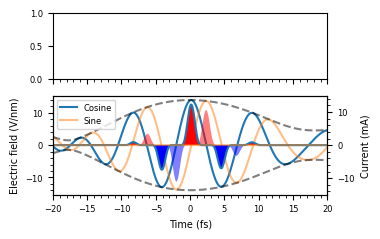

In [15]:

fig, ax1 = plt.subplots(2,1,gridspec_kw={'height_ratios': [1,1.5]},sharex=True,figsize=(cm*9,cm*6))


ax1[1].plot(timeAxis*1e15,np.real(np.exp(1j*cep)*eField))
ax1[1].plot(timeAxis*1e15,np.real(np.exp(1j*(cep-np.pi/2))*eField),alpha=0.5)
ax1[1].plot(timeAxis*1e15,np.abs(np.exp(1j*(cep-np.pi/2))*eField),'k--',alpha=0.5)
ax1[1].plot(timeAxis*1e15,-np.abs(np.exp(1j*(cep-np.pi/2))*eField),'k--',alpha=0.5)


ax1[1].set_xlim([-20,20])
ax1[1].minorticks_on()

ax1[1].set_ylabel('Electric field (V/nm)')
ax1[1].legend(['Cosine','Sine'])
ax2 = ax1[1].twinx()
ax2.plot(timeAxis*1e15,currentCosV2*1e3)
ax2.fill_between(timeAxis*1e15,currentCosV2*1e3,0,where=currentCosV2*1e3>0,facecolor='r',alpha=1)
ax2.fill_between(timeAxis*1e15,currentCosV2*1e3,0,where=currentCosV2*1e3<0,facecolor='b',alpha=1)



ax2.plot(timeAxis*1e15,currentSine*1e-15*convFactor*1e3,alpha=0.5)
ax2.fill_between(timeAxis*1e15,currentSineV2*1e3,0,where=currentSineV2*1e3>0,facecolor='r',alpha=0.5)
ax2.fill_between(timeAxis*1e15,currentSineV2*1e3,0,where=currentSineV2*1e3<0,facecolor='b',alpha=0.5)

ax2.minorticks_on()


ax2.set_ylabel('Current (mA)')
ax2.set_ylim([-15 , 15])


ax1[1].set_xlabel('Time (fs)')
plt.savefig('MIRCurrentPrincipleAmp.pdf',bbox_inches='tight')

plt.show()